# Projected Stochastic Gradient Ascent on D2



In [1]:
import numpy as np
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from matplotlib import pyplot as plt
import time as tm
import numpy as np
import random
Z = np.loadtxt( "data" )



def randsplit(ratio,Z):
    np.random.shuffle(Z)
    y = Z[:,0]
    X = Z[:,1:]
    X_train = X[:int(ratio*(X.shape[0])),:]
    y_train = y[:int(ratio*(X.shape[0]))]
    X_validate = X[int(ratio*(X.shape[0])):,:]
    y_validate = y[int(ratio*(X.shape[0])):]
    return X_train,X_validate,y_train,y_validate
  
def StratifiedSplit(ratio, Z):
    np.random.shuffle(Z)
    y = Z[:,0]
    X = Z[:,1:]
    Z_true = Z[y == 1]
    Z_false = Z[y == -1]
    X1_train,X1_validate,y1_train,y1_validate = randsplit(ratio,Z_true)
    X2_train,X2_validate,y2_train,y2_validate = randsplit(ratio,Z_false)
    X_train = np.concatenate((X1_train,X2_train))
    y_train = np.concatenate((y1_train,y2_train))
    X_validate = np.concatenate((X1_validate,X2_validate))
    y_validate = np.concatenate((y1_validate,y2_validate))
    return X_train,X_validate,y_train,y_validate


In [2]:
alpha = np.zeros(Z.shape[0])
w = np.zeros(Z.shape[1])
eta = 3
C = 1
(X,_,y,_) = randsplit(1,Z)
(n,) = y.shape
X = np.hstack((X, np.ones((n, 1))))
  
 

[1.44395000e-04 2.47903000e-04 3.33846000e-04 ... 3.79443902e+00
 3.79451282e+00 3.79458416e+00]


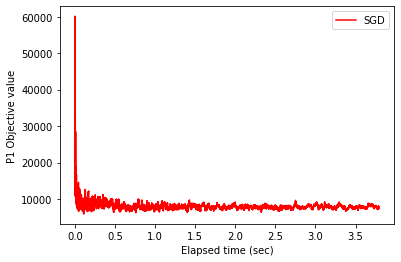

5914.256348114697
7423.628840201978


In [4]:
def getCyclicCoord( currentCoord ):
    if currentCoord >= n-1 or currentCoord < 0:
        return 0
    else:
        return currentCoord + 1

def getRandCoord( currentCoord ):
    return random.randint( 0, n-1 )

def getRandpermCoord( currentCoord ):
    global randperm, randpermInner
    if randpermInner >= n-1 or randpermInner < 0 or currentCoord < 0:
        randpermInner = 0
        randperm = np.random.permutation( y.size )
        return randperm[randpermInner]
    else:
        randpermInner = randpermInner + 1
        return randperm[randpermInner]

def getStepLength( grad, t ):
     return eta/np.sqrt(t+2)

# def getStepLength(grad, t ,power = 2):
#     return eta/pow(t+2,power)
def hingelossSq(theta):
    w = theta
#     b = theta[-1]
    
#     print("Nai")
    hingesq = np.square(np.maximum(1-np.multiply((X.dot(w)), y), 0))
    return np.sum(hingesq)

def ObjVal( theta ):
    w = theta[0:-1]
    b = theta[-1]
    Loss = hingelossSq(theta)
    return 0.5 * w.dot( w ) + C * Loss

def i_grad(alpha, i, w, X, y, C):
    return 1 - alpha[i]/(2*C) - 0.5*(y[i]**2)*alpha[i]*(np.linalg.norm(X[i])) - 0.5*(y[i]*(np.dot(w, X[i])))

def getCSVMObjValDual( alpha, w, C):
    # Recall that b is supposed to be treated as the last coordinate of w
    return np.sum(alpha) - np.sum(0.25 * np.square(alpha) /C ) - 0.5 * np.square(np.linalg.norm(w))
    

def Projected_Coordinate_Ascent( gradFunc, CoordFunc, stepFunc, init, w, horizon = 10):
    objValSeries = np.zeros( (horizon,) )
    timeSeries = np.zeros( (horizon,) )
    totTime = 0
    cumulative = init
    w=init
    i=-1
    for t in range( horizon ):
        tic = tm.perf_counter()
        i = CoordFunc( i )
        delta = i_grad(alpha, i, w, X, y, C)
        temp = alpha[i]*y[i]*X[i]
        alpha[i] = alpha[i] + stepFunc( delta, t+1 ) * delta
        if(alpha[i] < 0):
            alpha[i] = 0
        w = w - temp + alpha[i]*y[i]*X[i]
        toc = tm.perf_counter()
        totTime = totTime + (toc - tic)
        objValSeries[t] = ObjVal(w)
        timeSeries[t] = totTime
#         print(t)
    print(timeSeries)
    return (w, objValSeries, timeSeries)
  
def SGDP1():
  d=20
  (theta_SGD, obj_SGD, time_SGD) = Projected_Coordinate_Ascent( i_grad, getRandCoord, getStepLength, np.random.random_sample( (d+1,) ), w, horizon = 50000)
  plt.figure()
  plt.plot( time_SGD, obj_SGD, color = 'r', linestyle = '-', label = "SGD" )
  plt.xlabel( "Elapsed time (sec)" )
  plt.ylabel( "P1 Objective value" )
  plt.legend()
  plt.show()
  print(min(obj_SGD))
  print(ObjVal(theta_SGD))
#   print(theta_SGD)
  
SGDP1()
    